In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])

In [2]:
SAVE_DIR = Path().cwd() # mes/paper_plots
DATA_DIR = Path().cwd().parent / "data" # mes/data
assert DATA_DIR.exists(), f"{DATA_DIR} does not exist"

## Plotting HPs

We'll want to make different figures for different kernel types, and dimensionality?

In [3]:
df = pd.read_json(DATA_DIR / "benchmark_df_big.json")

df["regret"] = df.apply(lambda x: x["y_true_max"] - np.array(x["y_max_history"]), axis=1)
df = df.drop(columns=["y_true_max", "final_y_max", "y_max_history"]) # cleanup rows
df = df.explode(["regret", "steps"], ignore_index=True) # explode history into seperate rows
df["regret"] = pd.to_numeric(df["regret"], errors="raise")

# mean regret over the `n_y` runs
cols2group = [c for c in df.columns if c not in {"run_id", "regret"}]
df = df.groupby(cols2group).agg(['mean', 'std', 'count', 'min']).drop(columns="run_id") # .reset_index()
df = df.reset_index().set_index(['kernel_type', 'n_dim', 'acq_func', 'steps'])
df

len_scale        lr         wd  \
                                                                              
kernel_type n_dim acq_func             steps                                  
matern-3/2  2     expected_improvement 4            25  0.001000   0.000000   
                                       4            25  0.001000   0.010000   
                                       4            25  0.001000   0.014384   
                                       4            25  0.001000   0.020691   
                                       4            25  0.001000   0.029764   
...                                                ...       ...        ...   
matern-5/2  4     ves_mc_gamma         25           25  3.162278   2.335721   
                                       25           25  3.162278   3.359818   
                                       25           25  3.162278   4.832930   
                                       25           25  3.162278   6.951928   
                                       25           25  3.162278  10.000000   

                                             max_iters    regret            \
                                                            mean       std   
kernel_type n_dim acq_func             steps                                 
matern-3/2  2     expected_improvement 4           200  1.077830  0.594290   
                                       4           200  1.077830  0.594290   
                                       4           200  1.077830  0.594290   
                                       4           200  1.077830  0.594290   
                                       4           200  1.077830  0.594290   
...                                                ...       ...       ...   
matern-5/2  4     ves_mc_gamma         25          200  0.313317  0.428261   
                                       25          200  0.313317  0.428261   
                                       25          200  0.313317  0.428261   
                                       25          200  0.313317  0.428261   
                                       25          200  0.313317  0.428261   

                                                              
                                             count       min  
kernel_type n_dim acq_func             steps                  
matern-3/2  2     expected_improvement 4        32  0.109109  
                                       4        32  0.109109  
                                       4        32  0.109109  
                                       4        32  0.109109  
                                       4        32  0.109109  
...                                            ...       ...  
matern-5/2  4     ves_mc_gamma         25       32  0.000000  
                                       25       32  0.000000  
                                       25       32  0.000000  
                                       25       32  0.000000  
                                       25       32  0.000000  

[147840 rows x 8 columns]

## Plotting the best HPs found.

Ok this is a bit huge...

Basically what we want to do is find the best config for each `["acq_func", "kernel_type", "n_dim"]`.

Hey did you know you could put a lambda in a `.loc[]` which is the df after all the previous operations? Mind blowing.

In [4]:
# our index is the config
index = ["kernel_type", "n_dim", "acq_func"]

hps_search = (
    df
    .xs('mean', level=1, axis=1).reset_index() # extract the mean regret from the multiple n_y
    .loc[lambda x: x.steps == x.steps.max()] # extract only the last step
    .drop(columns="steps") # drop columns (not needed)
    .loc[lambda x: x.groupby(index).regret.idxmin()] # get the argmin regret and index into it
    .reset_index() # we would like to keep the original idx for this row
    .set_index(index)  # create MultiIndex, needed for plotting
)
hps_search

index    regret
kernel_type n_dim acq_func                              
matern-3/2  2     expected_improvement    8820  0.026676
                  random_search          45780  0.385353
                  ves_gamma              82858  0.006656
                  ves_mc_gamma          119916  0.005702
            4     expected_improvement   18060  0.475579
                  random_search          55020  0.354305
                  ves_gamma              92210  0.328331
                  ves_mc_gamma          129328  0.236469
matern-5/2  2     expected_improvement   27300  0.003472
                  random_search          64260  0.356056
                  ves_gamma             101324  0.000000
                  ves_mc_gamma          138258  0.000000
            4     expected_improvement   36540  0.393838
                  random_search          73500  0.500364
                  ves_gamma             110725  0.343353
                  ves_mc_gamma          147801  0.182238

In [5]:
df.index.get_level_values("acq_func").unique()

Index(['expected_improvement', 'random_search', 'ves_gamma', 'ves_mc_gamma'], dtype='object', name='acq_func')

This gives us a multi-index dataframe with unique keys of `(kernel_type, n_dim, acq_func, steps)` and mean, std, count regret for each row.

To index into a single kernel / dimension, we can use:

In [6]:
df.loc[('matern-3/2', 4)]

/var/folders/8l/m823kngj6n3fzx1hpgpv5f3c0000gq/T/ipykernel_93336/3358112588.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[('matern-3/2', 4)]


len_scale        lr         wd max_iters   regret  \
                                                                        mean   
acq_func             steps                                                     
expected_improvement 4            25  0.001000   0.000000       200  1.36606   
                     4            25  0.001000   0.010000       200  1.36606   
                     4            25  0.001000   0.014384       200  1.36606   
                     4            25  0.001000   0.020691       200  1.36606   
                     4            25  0.001000   0.029764       200  1.36606   
...                              ...       ...        ...       ...      ...   
ves_mc_gamma         25           25  3.162278   2.335721       200  0.26337   
                     25           25  3.162278   3.359818       200  0.26337   
                     25           25  3.162278   4.832930       200  0.26337   
                     25           25  3.162278   6.951928       200  0.26337   
                     25           25  3.162278  10.000000       200  0.26337   

                                                      
                                 std count       min  
acq_func             steps                            
expected_improvement 4      0.696906    32  0.275993  
                     4      0.696906    32  0.275993  
                     4      0.696906    32  0.275993  
                     4      0.696906    32  0.275993  
                     4      0.696906    32  0.275993  
...                              ...   ...       ...  
ves_mc_gamma         25     0.369787    32  0.000000  
                     25     0.369787    32  0.000000  
                     25     0.369787    32  0.000000  
                     25     0.369787    32  0.000000  
                     25     0.369787    32  0.000000  

[36960 rows x 8 columns]

kt=matern-3/2 nd=2 acq=expected_improvement lr=0.0010 wd=0.000
kt=matern-3/2 nd=2 acq=random_search lr=0.0010 wd=0.000
kt=matern-3/2 nd=2 acq=ves_gamma lr=0.0083 wd=0.785
kt=matern-3/2 nd=2 acq=ves_mc_gamma lr=0.0695 wd=0.062
kt=matern-3/2 nd=4 acq=expected_improvement lr=0.0010 wd=0.000
kt=matern-3/2 nd=4 acq=random_search lr=0.0010 wd=0.000
kt=matern-3/2 nd=4 acq=ves_gamma lr=0.0695 wd=10.000
kt=matern-3/2 nd=4 acq=ves_mc_gamma lr=2.0691 wd=0.264
/Users/tomp/work/mes/paper_plots/benchmark-matern-3_2.png
kt=matern-5/2 nd=2 acq=expected_improvement lr=0.0010 wd=0.000
kt=matern-5/2 nd=2 acq=random_search lr=0.0010 wd=0.000
kt=matern-5/2 nd=2 acq=ves_gamma lr=0.0055 wd=10.000
kt=matern-5/2 nd=2 acq=ves_mc_gamma lr=0.0036 wd=1.624
kt=matern-5/2 nd=4 acq=expected_improvement lr=0.0010 wd=0.000
kt=matern-5/2 nd=4 acq=random_search lr=0.0010 wd=0.000
kt=matern-5/2 nd=4 acq=ves_gamma lr=0.1624 wd=0.785
kt=matern-5/2 nd=4 acq=ves_mc_gamma lr=2.0691 wd=0.021
/Users/tomp/work/mes/paper_plots/ben

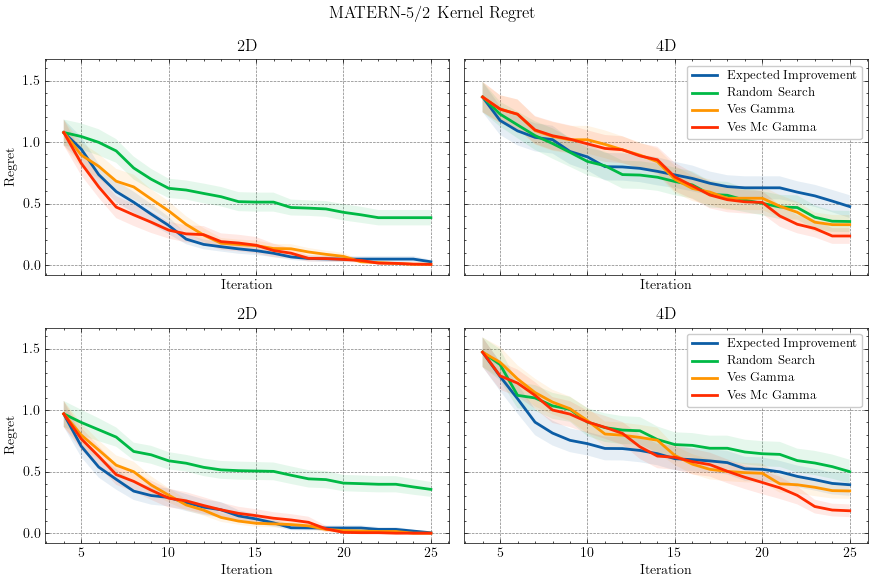

In [7]:
def plot_best_lines(df, hps_search, save_dir=None):
    # flatten columns -> 'regret_mean', etc.
    flat = df.copy()
    if isinstance(flat.columns, pd.MultiIndex):
        flat.columns = ['_'.join(map(str, c)).strip('_') for c in flat.columns]
    flat = flat.reset_index()

    fig, axes = plt.subplots(2, 2, figsize=(9, 6), sharey=True, sharex=True)
    for i, (kt, kdf) in enumerate(flat.groupby('kernel_type')):
        n_dims = sorted(kdf['n_dim'].unique())
        axs = axes[i]
        for ax, nd in zip(axs, n_dims):
            sub = kdf.query("n_dim == @nd")
            for acq in sorted(sub['acq_func'].unique()):
                idx = int(hps_search.loc[(kt, nd, acq), 'index'])
                row = flat.iloc[idx]
                lr_v, wd_v = row['lr'], row['wd'] # best lr and wd
                print(f"kt={kt} nd={nd} acq={acq} lr={lr_v:.4f} wd={wd_v:.3f}")

                best = sub.query("acq_func == @acq and lr == @lr_v and wd == @wd_v").sort_values('steps')

                x, y = best['steps'].to_numpy(), best['regret_mean'].to_numpy()
                ax.plot(x, y, label=acq.replace('_',' ').title(), linewidth=2)

                se = best['regret_std'].to_numpy() / np.sqrt(best['regret_count'].to_numpy())
                ax.fill_between(x, y - se, y + se, alpha=0.1)

                # if acq == 'ves_gamma' and 'regret_min' in best.columns:
                #     ax.plot(x, best['regret_min'].to_numpy(), '--', label=f"{acq.title()} Min", linewidth=2)

            ax.set_title(f"{nd}D")
            ax.set_xlabel("Iteration")
        axs[0].set_ylabel("Regret")
        axs[-1].legend(fontsize=9)
        fig.suptitle(f"{kt.upper()} Kernel Regret")
        plt.tight_layout()
        if save_dir:
            p = Path(save_dir) / f"benchmark-{kt.replace('/','_')}.png"
            fig.savefig(p, dpi=300)
            print(p)
    plt.show()

plot_best_lines(df, hps_search, save_dir=SAVE_DIR)

/var/folders/8l/m823kngj6n3fzx1hpgpv5f3c0000gq/T/ipykernel_93336/178077974.py:27: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subfig.subplots_adjust(top=0.94, wspace=0.15)  # tighten space under the title
/var/folders/8l/m823kngj6n3fzx1hpgpv5f3c0000gq/T/ipykernel_93336/178077974.py:27: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subfig.subplots_adjust(top=0.94, wspace=0.15)  # tighten space under the title


kt=matern-3/2 nd=2 acq=expected_improvement lr=0.0010 wd=0.000
kt=matern-3/2 nd=2 acq=random_search lr=0.0010 wd=0.000
kt=matern-3/2 nd=2 acq=ves_gamma lr=0.0083 wd=0.785
kt=matern-3/2 nd=2 acq=ves_mc_gamma lr=0.0695 wd=0.062
kt=matern-3/2 nd=4 acq=expected_improvement lr=0.0010 wd=0.000
kt=matern-3/2 nd=4 acq=random_search lr=0.0010 wd=0.000
kt=matern-3/2 nd=4 acq=ves_gamma lr=0.0695 wd=10.000
kt=matern-3/2 nd=4 acq=ves_mc_gamma lr=2.0691 wd=0.264
/Users/tomp/work/mes/paper_plots/benchmark-matern-3_2.png
kt=matern-5/2 nd=2 acq=expected_improvement lr=0.0010 wd=0.000
kt=matern-5/2 nd=2 acq=random_search lr=0.0010 wd=0.000
kt=matern-5/2 nd=2 acq=ves_gamma lr=0.0055 wd=10.000
kt=matern-5/2 nd=2 acq=ves_mc_gamma lr=0.0036 wd=1.624
kt=matern-5/2 nd=4 acq=expected_improvement lr=0.0010 wd=0.000
kt=matern-5/2 nd=4 acq=random_search lr=0.0010 wd=0.000
kt=matern-5/2 nd=4 acq=ves_gamma lr=0.1624 wd=0.785
kt=matern-5/2 nd=4 acq=ves_mc_gamma lr=2.0691 wd=0.021
/Users/tomp/work/mes/paper_plots/ben

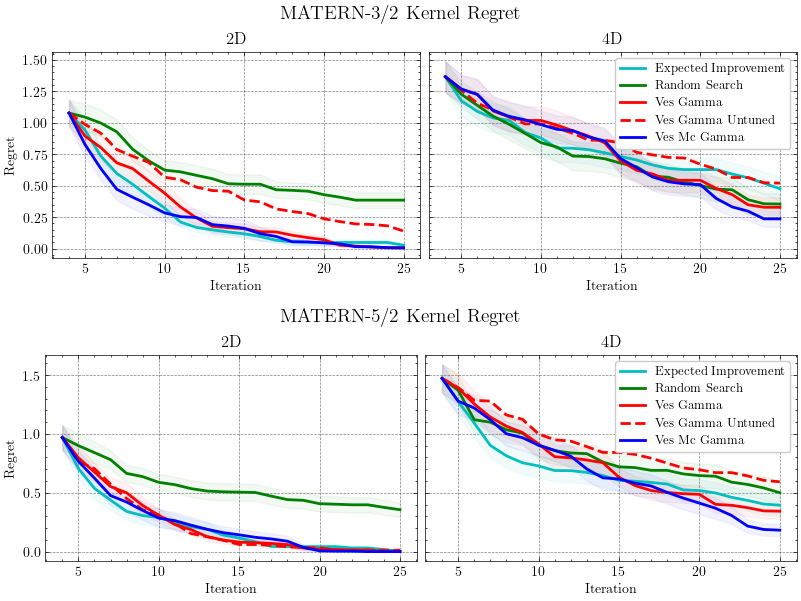

In [11]:
styles = {
    "ves_gamma": "r",
    "ves_gamma_naive": "r--",
    "ves_mc_gamma": "b",
    "random_search": "g",
    "expected_improvement": "c"
}

def plot_best_lines(df, hps_search, save_dir=None):
    # flatten columns -> 'regret_mean', etc.
    flat = df.copy()
    if isinstance(flat.columns, pd.MultiIndex):
        flat.columns = ['_'.join(map(str, c)).strip('_') for c in flat.columns]
    flat = flat.reset_index()

    kts = sorted(flat['kernel_type'].unique())
    n_dims_all = sorted(flat['n_dim'].unique())
    ncols = len(n_dims_all)

    # One subfigure per kernel_type
    fig = plt.figure(figsize=(ncols * 4, len(kts) * 3), constrained_layout=True)
    gs = fig.add_gridspec(nrows=len(kts), ncols=1, hspace=0.02)
    subfigs = [fig.add_subfigure(gs[i, 0]) for i in range(len(kts))]

    for kt, subfig in zip(kts, subfigs):
        subfig.suptitle(f"{kt.upper()} Kernel Regret", fontsize=14, fontweight='bold')
        subfig.subplots_adjust(top=0.94, wspace=0.15)  # tighten space under the title

        axs = subfig.subplots(nrows=1, ncols=ncols, sharey=True, sharex=True)

        for ax, nd in zip(axs, n_dims_all):
            sub = flat.query("kernel_type == @kt and n_dim == @nd")
            if sub.empty:
                ax.set_visible(False)
                continue

            for acq in sorted(sub['acq_func'].unique()):
                idx = int(hps_search.loc[(kt, nd, acq), 'index'])
                row = flat.iloc[idx]
                lr_v, wd_v = row['lr'], row['wd']
                print(f"kt={kt} nd={nd} acq={acq} lr={lr_v:.4f} wd={wd_v:.3f}")

                best = sub.query("acq_func == @acq and lr == @lr_v and wd == @wd_v").sort_values('steps')
                x, y = best['steps'].to_numpy(), best['regret_mean'].to_numpy()
                ax.plot(x, y, styles[acq], label=acq.replace('_',' ').title(), linewidth=2)
                se = best['regret_std'].to_numpy() / np.sqrt(best['regret_count'].to_numpy())
                ax.fill_between(x, y - se, y + se, color=styles[acq], alpha=0.05)

                if acq == "ves_gamma":
                    naive_lr = 1.35387618e+00
                    naive_wd = 0
                    naive = sub.query("acq_func == @acq and lr == @naive_lr and wd == @naive_wd").sort_values('steps')
                    x, y = naive['steps'].to_numpy(), naive['regret_mean'].to_numpy()
                    ax.plot(x, y, "r--", label=acq.replace('_',' ').title() + ' Untuned', linewidth=2)

            ax.set_title(f"{nd}D")
            ax.set_xlabel("Iteration")
        axs[0].set_ylabel("Regret")
        axs[-1].legend(fontsize=9)

        if save_dir:
            p = Path(save_dir) / f"benchmark-{kt.replace('/','_')}.png"
            # subfig.savefig(p, dpi=300)
            print(p)

    plt.show()
plot_best_lines(df, hps_search, save_dir=SAVE_DIR)